# **Fully Connected Auxiliary Classifier GAN (AC-GANs)**

To augment the vanilla GAN built with guidance from the course lab with an Auxiliary Classifier (creating a vanilla AC-GAN), we make two major changes: (1) the Generator takes as input a latent vector z with a concatenated one-hot label vector c, and (2) the losses of the Generator and Discriminator are altered so the Generator learns how to output a specific clothing item type requested.

For the first change, we define the function modified_sample_noise. For the second, we implement the additional classification loss and add it to the vanilla GAN loss. 


# **Setup**
Here we recycle supplementary code from the lab.

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np

tf.keras.backend.set_floatx('float64')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap="gray_r")
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


# Load data from Google Drive
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3', cache_discovery=False)

fid = "1r6i_ftDFkjFy6mUq-CNTH1JeN_C0xqDh"


from IPython.display import HTML, display
def progress_bar(value):
    return HTML("""
        <progress
            value='{value}'
            max='100', style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value*100))
request = drive_service.files().get_media(fileId=fid)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
progress_bar_html = display(progress_bar(0), display_id=True)
while not done:
  
  progress, done = downloader.next_chunk()
  progress_bar_html.update(progress_bar(progress.progress()))

print("Done.")
downloaded.seek(0)

# A dict with keys {"lrelu_x", "lrelu_y", "logits_real", "logits_fake", "d_loss_true", "g_loss_true"}
# Only used for testing your loss/activation functions, not for training your GAN
answers = np.load(downloaded)

Done.


## **Fashion MNIST Dataset**
Knowing from the lab that "GANs are notoriously finicky with hyperparameters, and also require many training epochs" we decided to start with the Fashion MNIST Dataset to kickstart the development of our model. This would make tuning and training much more manageable before augmenting classification, resolution, and ultimately textures and more robust datasets.

4431872/4422102 [==============================] - 0s 0us/step


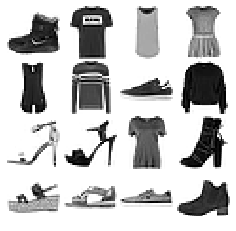

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = np.reshape(train_images, [train_images.shape[0], -1])
show_images(train_images[:16])
train_images = train_images / 255.0

mnist_images = tf.data.Dataset.from_tensor_slices(train_images)
mnist_labels = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int32))

mnist = tf.data.Dataset.zip((mnist_images, mnist_labels))

## **Random Noise and Labels**
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1, with concatenated one-hot label vectors of length `num_classes`, to produce shape `[batch_size, dim + num_classes]`, as well as a TensorFlow `Tensor` containingly the randomly generated labels from 0 to num_classes with shape `[batch_size,]` to be used in loss calculation.

In [ ]:
def modified_sample_noise(batch_size: int, dim: int, num_classes: int, testing=False, input_label=None) -> tf.Tensor:
    latent_tensor = tf.random.uniform(shape=[batch_size, dim], minval=-1, maxval=1) # [batch_size, dim]
    label_tensor = tf.random.uniform(shape=[batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
    one_hot_labels = tf.one_hot(label_tensor, num_classes) # [batch_size, num_classes]

    if testing:
      label_tensor = input_label
      one_hot_labels = tf.one_hot(input_label, num_classes)

    tensor = tf.concat([latent_tensor, one_hot_labels], 1)

    return tensor, label_tensor

# **Building the Discriminator and the Generator**

Similarly to the lab, we separated the discriminator and the generator into two separate models for clarity and simplicity. While the layers in both are modeled after the vanilla GAN architecture from the lab, the key difference is found in the loss functions, as discussed earlier.

## Discriminator
The architecture of the discriminator was adapted to suit two outputs, rather than one: the binary prediction as well as the classification prediction.

Architecture:

 * Dense layer from 784 to 256 with LeakyReLU activation with alpha 0.01
 * Dense layer from 256 to 256 with LeakyReLU activation with alpha 0.01
 * For binary prediction output: Dense layer from 256 to 1 with no activation
 * For classification prediction output: Dense layer from 256 to 10 with softmax activation

The outputs of the discriminator should have shapes `[batch_size, 1]`, for whether each of the `batch_size` inputs are real images, and `[batch_size, 10]` for the probability predictions of the class labels.

In [ ]:
class Discriminator(tf.keras.Model):
  
  """Model class for the discriminator"""
  def __init__(self,):
    super(Discriminator, self).__init__()
    
    self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01)

    # trainable weights for pixels given noise and specific class label
    self.features = tf.keras.Sequential([
                                         tf.keras.layers.Dense(256, activation=self.leaky_relu),
                                         tf.keras.layers.Dense(256, activation=self.leaky_relu)
    ])
    
    # both trainable predictions for real vs fake and class
    self.binary_pred = tf.keras.layers.Dense(1)
    self.classifier = tf.keras.layers.Dense(10, activation='softmax')
   
  @tf.function
  def call(self, x: tf.Tensor) -> tf.Tensor:
    """Compute discriminator scores and classification predictions for a batch 
    of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image,
    and TensorFlow Tensor with shape [batch_size, 10], containing the 
    probability predictions for the class labels.
    """
    # both predictions share the same weights
    weight = self.features(x)

    binary_pred = self.binary_pred(weight)
    class_pred = self.classifier(weight)

    return binary_pred, class_pred
    
  @tf.function
  def loss_function(self, logits_fake, logits_real, class_fake, class_real, class_labels_fake, class_labels_real):
    """Compute the loss for the discriminator that optimizies correct real vs fake prediction and category classification.

    Inputs:
    - logits_fake: binary_pred output of calling discriminator with fake images
    - logits_real: binary_pred output of calling discriminator with real images
    - class_fake: class_pred output of calling discriminator with fake images
    - class_real: class_pred output of calling discriminator with real images
    - class_labels_fake: class labels generated by modified_sample_noise, taken as input to generate fake images
    - class_labels_real: class labels associated with real images from dataset

    Returns:
    A scalar tensor with the average loss for the batch.
    """
    # traditional GAN loss
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real))

    # categorical classification loss
    class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_fake, class_fake)
    class_loss += tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_real, class_real)

    D_loss += class_loss

    return tf.reduce_mean(D_loss) 

## **Generator**
The architecture of the generator likewise takes after that of the lab, but its input is now a concatenation of the sampled latent noise and randomly sampled class labels.

 * Dense layer from (noise_dim + num_classes) to 1024 with LeakyReLU activation 
 * Dense layer from 1024 to 1024 with LeakyReLU activation
 * Dense layer from 1024 to 784 with **TanH** activation to restrict the pixel values to be [-1,1]

Again, apart from the input change that allows the Generator to learn class label association weights, a major change is in the loss. 

In [ ]:
class Generator(tf.keras.Model):
  
  """Model class for the generator"""
  def __init__(self):
    super(Generator, self).__init__()
    
    self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01)
    self.features = tf.keras.Sequential([
                                         tf.keras.layers.Dense(1024, activation=self.leaky_relu), 
                                         tf.keras.layers.Dense(1024, activation=self.leaky_relu),
                                         tf.keras.layers.Dense(784, activation='tanh')
    ])
   
  @tf.function
  def call(self, x: tf.Tensor) -> tf.Tensor:
    """Generates a batch of images given a tensor of noise + label vectors.
    
    Inputs:
    - x: A [batch_size, noise_dim + num_classes] tensor of noise + label vectors
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 784], containing the generated images.
    """
    return self.features(x)
    
  @tf.function
  def loss_function(self, logits_fake, class_fake, class_real, class_labels_fake, class_labels_real):
    """Compute the loss for the generator that maximizes incorrect discriminator 
    guess of fake as real and correct category classification by the discriminator.

    Inputs:
    - logits_fake: binary_pred output of calling discriminator with fake images
    - class_fake: class_pred output of calling discriminator with fake images
    - class_real: class_pred output of calling discriminator with real images
    - class_labels_fake: class labels generated by modified_sample_noise, taken as input to generate fake images
    - class_labels_real: class labels associated with real images from dataset

    Returns:
    A scalar tensor with the average loss for the batch.
    """
    # ones indicate guess as real
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= tf.ones_like(logits_fake), logits=logits_fake))

    # get class_loss from discriminator
    class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_fake, class_fake)
    class_loss += tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_real, class_real)

    G_loss += class_loss

    return tf.reduce_mean(G_loss)
        

# Optimizing Loss and Training
Like usual, we optimize our loss we use the `Keras AdamOptimizer` with a 1e-3 learning rate and $\beta_1$ of 0.5. We use Gradient Tape to calculate and apply the gradients.

We then train over 10 epochs.

In [ ]:
learning_rate=1e-3
beta_1=0.5

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1)

def optimize(tape: tf.GradientTape, model: tf.keras.Model, loss: tf.Tensor) -> None:
  """ This optimizes a model with respect to its loss
  
  Inputs:
  - tape: the Gradient Tape
  - model: the model to be updated
  - loss: the model's loss
  """
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
def accuracy(logits, labels):
      """
      Calculates the discriminator's classification accuracy by comparing
      logits to correct labels.
      
      :param logits: a matrix of size (num_inputs, num_classes); during training, this will be (batch_size, num_classes)
      containing the softmax probability predictions for each class
      :param labels: a matrix of size (num_inputs,) containing the answers, during training, this will be (batch_size,)
      
      :return: the accuracy of the model as a Tensor
      """
      correct_predictions = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), labels)
      return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
num_classes = 10

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# create generator and discriminator
generator_model = Generator()
generator_model.build((batch_size, noise_dim + num_classes))
discriminator_model = Discriminator()
discriminator_model.build((batch_size, 784))

def train(x, c):
  # random noise fed into our generator
  z, class_labels_fake = modified_sample_noise(batch_size, noise_dim, num_classes)

  with tf.GradientTape(persistent=True) as tape:
    # generated images
    G_sample = generator_model(z)

    # scale images to be -1 to 1
    logits_real, class_real = discriminator_model(preprocess_img(x))
    # re-use discriminator weights on new inputs
    logits_fake, class_fake = discriminator_model(G_sample)
    # calculate mean fake and real classification accuracies
    real_class_acc = accuracy(logits_real, c)
    fake_class_acc = accuracy(logits_fake, class_labels_fake)
    batch_accuracy = (real_class_acc + fake_class_acc) / 2

    g_loss = generator_model.loss_function(logits_fake, class_fake, class_real, class_labels_fake, c)
    d_loss = discriminator_model.loss_function(logits_fake, logits_real, class_fake, class_real, class_labels_fake, c)
    
  # call optimize on the generator and the discriminator
  optimize(tape, generator_model, g_loss)
  optimize(tape, discriminator_model, d_loss)
  
  return g_loss, d_loss, batch_accuracy

## Finally, train the model below

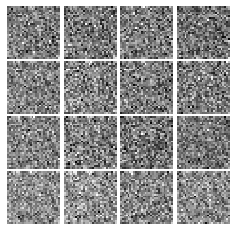


Iter: 0, D: 5.862, G:5.337
Accuracy: 0.109375
Iter: 50, D: 4.322, G:6.684
Accuracy: 0.08984375
Iter: 100, D: 4.746, G:4.87
Accuracy: 0.1015625
Iter: 150, D: 4.712, G:5.366
Accuracy: 0.1171875
Iter: 200, D: 4.502, G:5.986
Accuracy: 0.09765625


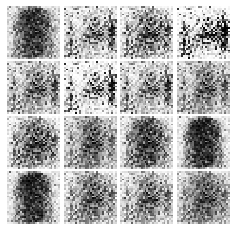


Iter: 250, D: 4.812, G:5.936
Accuracy: 0.109375
Iter: 300, D: 4.571, G:6.148
Accuracy: 0.09375
Iter: 350, D: 4.727, G:5.978
Accuracy: 0.08984375
Iter: 400, D: 6.048, G:4.047
Accuracy: 0.12109375
Iter: 450, D: 5.055, G:4.292
Accuracy: 0.11328125


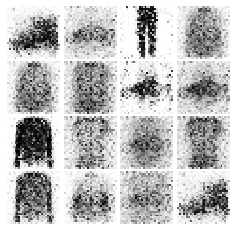


Iter: 500, D: 4.193, G:4.584
Accuracy: 0.0859375
Iter: 550, D: 4.345, G:5.552
Accuracy: 0.1015625
Iter: 600, D: 4.239, G:4.271
Accuracy: 0.11328125
Iter: 650, D: 4.141, G:4.201
Accuracy: 0.11328125
Iter: 700, D: 4.201, G:4.791
Accuracy: 0.10546875


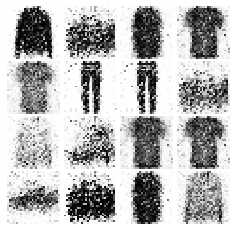


Iter: 750, D: 4.04, G:4.318
Accuracy: 0.1171875
Iter: 800, D: 4.667, G:3.587
Accuracy: 0.10546875
Iter: 850, D: 4.239, G:5.187
Accuracy: 0.12109375
Iter: 900, D: 4.113, G:4.409
Accuracy: 0.09375
Iter: 950, D: 4.413, G:4.877
Accuracy: 0.09375


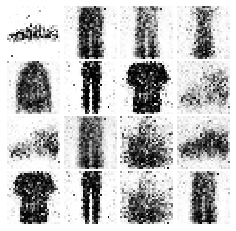


Iter: 1000, D: 4.099, G:4.359
Accuracy: 0.08984375
Iter: 1050, D: 4.808, G:3.457
Accuracy: 0.1015625
Iter: 1100, D: 4.401, G:4.179
Accuracy: 0.07421875
Iter: 1150, D: 4.185, G:4.235
Accuracy: 0.07421875
Iter: 1200, D: 4.62, G:3.672
Accuracy: 0.0859375


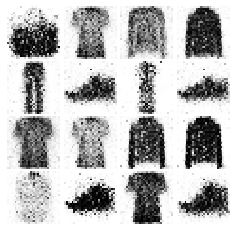


Iter: 1250, D: 4.201, G:4.873
Accuracy: 0.12109375
Iter: 1300, D: 4.438, G:4.936
Accuracy: 0.109375
Iter: 1350, D: 4.274, G:4.497
Accuracy: 0.078125
Iter: 1400, D: 4.168, G:4.231
Accuracy: 0.0859375
Iter: 1450, D: 4.492, G:3.641
Accuracy: 0.11328125


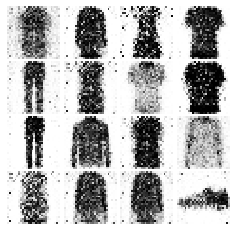


Iter: 1500, D: 4.23, G:4.293
Accuracy: 0.09765625
Iter: 1550, D: 4.685, G:3.608
Accuracy: 0.09375
Iter: 1600, D: 4.062, G:4.075
Accuracy: 0.08203125
Iter: 1650, D: 4.392, G:3.803
Accuracy: 0.125
Iter: 1700, D: 4.354, G:3.828
Accuracy: 0.08984375


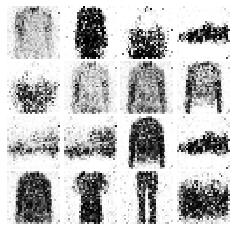


Iter: 1750, D: 4.182, G:3.892
Accuracy: 0.1015625
Iter: 1800, D: 4.332, G:3.974
Accuracy: 0.08984375
Iter: 1850, D: 4.245, G:3.957
Accuracy: 0.13671875
Iter: 1900, D: 4.379, G:3.884
Accuracy: 0.1171875
Iter: 1950, D: 4.225, G:3.832
Accuracy: 0.12890625


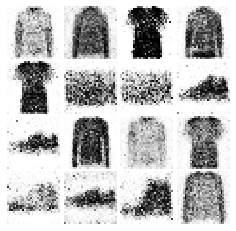


Iter: 2000, D: 4.27, G:4.091
Accuracy: 0.09765625
Iter: 2050, D: 4.231, G:4.151
Accuracy: 0.09375
Iter: 2100, D: 4.289, G:4.03
Accuracy: 0.10546875
Iter: 2150, D: 4.345, G:4.403
Accuracy: 0.109375
Iter: 2200, D: 4.315, G:4.268
Accuracy: 0.1171875


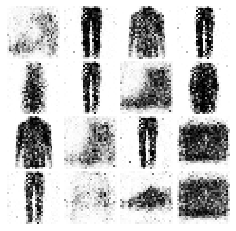


Iter: 2250, D: 4.337, G:4.028
Accuracy: 0.09375
Iter: 2300, D: 4.478, G:3.95
Accuracy: 0.078125
Iter: 2350, D: 4.129, G:4.097
Accuracy: 0.05078125
Iter: 2400, D: 4.661, G:4.184
Accuracy: 0.15625
Iter: 2450, D: 4.725, G:3.532
Accuracy: 0.0625


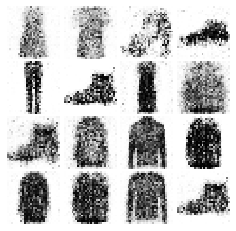


Iter: 2500, D: 4.55, G:4.019
Accuracy: 0.1015625
Iter: 2550, D: 4.289, G:3.949
Accuracy: 0.11328125
Iter: 2600, D: 4.303, G:4.307
Accuracy: 0.12890625
Iter: 2650, D: 4.34, G:4.031
Accuracy: 0.109375
Iter: 2700, D: 4.333, G:4.054
Accuracy: 0.0703125


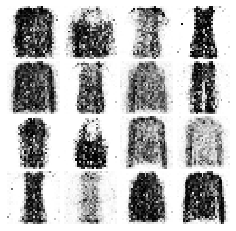


Iter: 2750, D: 4.278, G:3.917
Accuracy: 0.125
Iter: 2800, D: 4.345, G:4.549
Accuracy: 0.11328125
Iter: 2850, D: 4.32, G:3.917
Accuracy: 0.078125
Iter: 2900, D: 4.542, G:3.664
Accuracy: 0.08203125
Iter: 2950, D: 4.342, G:3.95
Accuracy: 0.109375


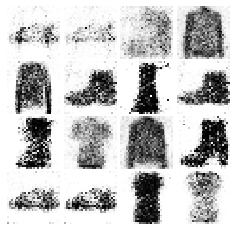


Iter: 3000, D: 4.147, G:4.042
Accuracy: 0.09375
Iter: 3050, D: 4.207, G:3.979
Accuracy: 0.0703125
Iter: 3100, D: 4.483, G:3.798
Accuracy: 0.09375
Iter: 3150, D: 4.282, G:3.961
Accuracy: 0.13671875
Iter: 3200, D: 4.371, G:3.813
Accuracy: 0.15234375


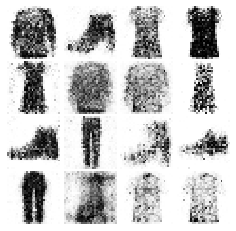


Iter: 3250, D: 4.335, G:4.08
Accuracy: 0.09375
Iter: 3300, D: 4.316, G:3.968
Accuracy: 0.08984375
Iter: 3350, D: 4.442, G:4.048
Accuracy: 0.09375
Iter: 3400, D: 4.469, G:3.859
Accuracy: 0.12109375
Iter: 3450, D: 4.323, G:3.868
Accuracy: 0.1484375


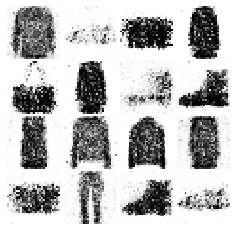


Iter: 3500, D: 4.272, G:4.031
Accuracy: 0.0703125
Iter: 3550, D: 4.465, G:3.783
Accuracy: 0.14453125
Iter: 3600, D: 4.417, G:3.87
Accuracy: 0.0859375
Iter: 3650, D: 4.481, G:3.943
Accuracy: 0.078125
Iter: 3700, D: 4.377, G:4.031
Accuracy: 0.11328125


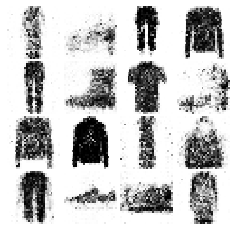


Iter: 3750, D: 4.299, G:3.869
Accuracy: 0.10546875
Iter: 3800, D: 4.332, G:3.956
Accuracy: 0.09765625
Iter: 3850, D: 4.342, G:3.884
Accuracy: 0.08203125
Iter: 3900, D: 4.363, G:3.931
Accuracy: 0.11328125
Iter: 3950, D: 4.294, G:3.92
Accuracy: 0.08203125


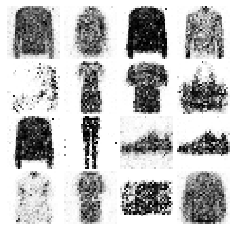


Iter: 4000, D: 4.294, G:4.01
Accuracy: 0.109375
Iter: 4050, D: 4.392, G:3.833
Accuracy: 0.12109375
Iter: 4100, D: 4.446, G:3.847
Accuracy: 0.10546875
Iter: 4150, D: 4.415, G:3.844
Accuracy: 0.078125
Iter: 4200, D: 4.406, G:3.841
Accuracy: 0.10546875


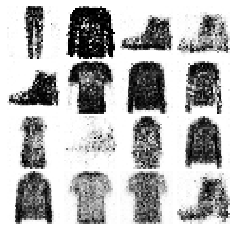


Iter: 4250, D: 4.324, G:3.994
Accuracy: 0.10546875
Iter: 4300, D: 4.407, G:3.787
Accuracy: 0.0859375
Iter: 4350, D: 4.378, G:3.951
Accuracy: 0.12109375
Iter: 4400, D: 4.412, G:3.878
Accuracy: 0.09765625
Iter: 4450, D: 4.327, G:3.99
Accuracy: 0.09375


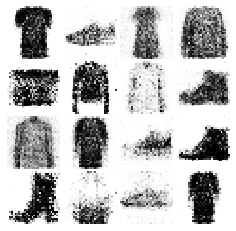


Iter: 4500, D: 4.453, G:4.1
Accuracy: 0.08984375
Iter: 4550, D: 4.431, G:3.895
Accuracy: 0.09375
Iter: 4600, D: 4.39, G:4.372
Accuracy: 0.1171875
Iter: 4650, D: 4.382, G:3.867
Accuracy: 0.12890625
tf.Tensor(0.10002234, shape=(), dtype=float32)


In [ ]:
# a giant helper function
def run_a_gan(show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    it = 0
    mnist1 = mnist.repeat(num_epoch).shuffle(batch_size).batch(batch_size, drop_remainder=True)
    batch_accuracies = []
   
    for minibatch in mnist1:
      minibatch_x = minibatch[0]
      minibatch_c = minibatch[1]
      # every show often, show a sample result
      if it % show_every == 0:
          z, _ = modified_sample_noise(batch_size, noise_dim, num_classes)
          samples = generator_model(z)
          fig = show_images(samples[:16])
          plt.show()
          print()
      # run a batch of data through the network
      G_loss_curr, D_loss_curr, batch_accuracy = train(minibatch_x, minibatch_c)
      batch_accuracies.append(batch_accuracy)
      
      # print loss every so often.
      # We want to make sure D_loss doesn't go to 0
      if it % print_every == 0:
          print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, D_loss_curr, G_loss_curr))
          print('Accuracy: {}'.format(batch_accuracy))
      it += 1

    batch_accuracies = tf.convert_to_tensor(batch_accuracies)
    final_acc = tf.reduce_mean(batch_accuracies)
    print(final_acc)

run_a_gan()




# Generate an Outfit!

We define a function `generate_outfit`, which takes the trained generator and a Tensor of any length (number of pieces desired in the outfit) containing the labels of the requested articles of clothing.

### generate_outfit


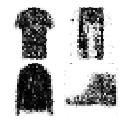

In [ ]:
def generate_outfit(generator_model, input_categories):
    num_items = len(input_categories)
    z, _ = modified_sample_noise(num_items, noise_dim, num_classes, testing=True, input_label=input_categories)

    fig = show_images(generator_model(z))
    plt.show()
  
input = tf.fill((20), 0)
tensor = tf.constant([0,1,4,9])

generate_outfit(generator_model, tensor)

##Try it!
Use the following key to generate an outfit inspired by your closet!

* T-shirt
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Input your items to choices and run the following cell blocks to make your outfit


In [ ]:
choices = ['T-shirt', 'Trouser', 'Coat', 'Ankle boot']

In [ ]:
#@title
output = []

for x in choices:
  if x == 'T-shirt':
    output.append(0)
  if x == 'Trouser':
    output.append(1)
  if x == 'Pullover':
    output.append(2)
  if x == 'Dress':
    output.append(3)
  if x == 'Coat':
    output.append(4)
  if x == 'Sandal':
    output.append(5)
  if x == 'Shirt':
    output.append(6)
  if x == 'Sneaker':
    output.append(7)
  if x == 'Bag':
    output.append(8)
  if x == 'Ankle boot':
    output.append(9)

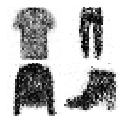

In [ ]:

tensor = tf.constant(output)

generate_outfit(generator_model, tensor)

# **Super Resolution (ESRGAN)**

Bonus: Imported pre-trained Super Resolution GAN to improve the resolution of the vanilla GAN images.

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2021-12-10 12:38:07--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.002s  

2021-12-10 12:38:07 (13.4 MB/s) - ‘original.png’ saved [34146/34146]



## Defining helper functions

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

## Performing Super Resolution of images

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



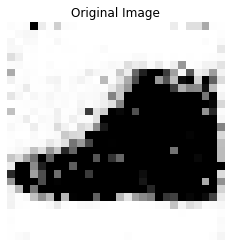

In [ ]:
input = tf.constant([9])

z, _ = modified_sample_noise(len(input), noise_dim, num_classes, testing=True, input_label=input)

test_img = generator_model(z) * -255
# print(test_img)

# Plotting Original Resolution image
plot_image(tf.reshape(test_img, [28,28]), title="Original Image")

## Experiment 1: Super Resolution with Original Generator Output

In [ ]:
test_img = tf.reshape(test_img, [784,1])
zeros_channel = tf.zeros_like(test_img)

input_img = tf.concat([test_img, zeros_channel, zeros_channel], 1)
input_img = tf.expand_dims(input_img, 0)
input_img = tf.expand_dims(input_img, 0)
input_img = tf.cast(tf.reshape(input_img, [1, 28, 28, 3]), tf.float32)
print(input_img.shape)

start = time.time()
fake_image = model(input_img)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

(1, 28, 28, 3)
Time Taken: 8.381991


In [ ]:
# try avg pool after
ap_test = tf.expand_dims(result_grayscale_img, 0)
ap_test = tf.expand_dims(result_grayscale_img, 0)
ap_test = tf.reshape(result_grayscale_img, [1,112,112,1])

ap_output = ap(ap_test)
print(ap_output.shape)
# print(ap_output)

plot_image(tf.squeeze(ap_output), title="Avg Pooled SR Image")

NameError: ignored

In [ ]:
# Plotting Super Resolution Image
result_grayscale_img = tf.reduce_sum(tf.squeeze(fake_image), axis=2)

print(result_grayscale_img.shape)

plot_image(result_grayscale_img, title="Super Resolution")

In [ ]:
# try max pool after
# mp = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same')

mp_test = tf.expand_dims(result_grayscale_img, 0)
mp_test = tf.expand_dims(result_grayscale_img, 0)
mp_test = tf.reshape(result_grayscale_img, [1,112,112,1])
print(mp_test.shape)

mp_output = mp(mp_test)
print(mp_output.shape)

plot_image(tf.squeeze(mp_output), title="Max Pooled Image")

## Experiment 2: post avg pooling

In [ ]:
# try avg pooling
ap = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')

ap_test = tf.expand_dims(test_img, 0)
ap_test = tf.expand_dims(test_img, 0)
ap_test = tf.reshape(test_img, [1,28,28,1])
print(ap_test.shape)

ap_output = ap(ap_test)

print(ap_output.shape)

plot_image(tf.squeeze(ap_output), title="Avg Pooled Image")
save_image(tf.squeeze(ap_output), filename="Avg Pooled Image")

In [ ]:
ap_output = tf.reshape(tf.squeeze(ap_output), [784,1])
zeros_channel = tf.zeros_like(ap_output)

input_img = tf.concat([test_img, zeros_channel, zeros_channel], 1)
input_img = tf.expand_dims(input_img, 0)
input_img = tf.expand_dims(input_img, 0)
input_img = tf.cast(tf.reshape(input_img, [1, 28, 28, 3]), tf.float32)
print(input_img.shape)

start = time.time()
fake_image = model(input_img)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

# Plotting Super Resolution Image
result_grayscale_img = tf.reduce_sum(tf.squeeze(fake_image), axis=2)

plot_image(result_grayscale_img, title="Super Resolution")
save_image(result_grayscale_img, filename="Super Resolution")

## maxpool experiment

In [ ]:
# try max pooling
mp = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding='same')

mp_test = tf.expand_dims(test_img, 0)
mp_test = tf.expand_dims(test_img, 0)
mp_test = tf.reshape(test_img, [1,28,28,1])
print(mp_test.shape)

mp_output = mp(mp_test)

print(mp_output.shape)

plot_image(tf.squeeze(mp_output), title="Max Pooled Image")